### And welcome to Week 4, Day 3 - more LangGraph..

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain_openai import ChatOpenAI
from typing import TypedDict


In [5]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)


True

### First, let's go set up LangSmith!

https://langsmith.com

### Next, here is a useful function in LangChain community:

In [8]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("Qual a capital do Brasil? Responda em português.")

'Brasília é atualmente a capital do Brasil e sede do governo do Distrito Federal. A atual capital do Brasil é Brasília, localizada na Região Centro-Oeste, ... Em 1960, tivemos uma nova mudança: a capital passou a ser Brasília. O presidente da época, Juscelino Kubitschek, tinha a ideia de povoar a região central do ... O Brasil conta com 26 capitais estaduais e uma capital federal, Brasília, situada no Distrito Federal. Essa é a terceira cidade a servir de sede do governo ... Qual é a capital do Brasil? Descubra a resposta aqui! Descubra a capital do Brasil de forma divertida neste vídeo engraçado. Brasília é a ... Missing: Responda | Show results with:Responda. Em 1960 a capital do Brasil passou a ser Brasília. Antes, foi o Rio de Janeiro. Mas a primeira capital foi Salvador. Até 1763, quando houve ... O Brasil é um país da América do Sul e tem como capital a cidade de Brasília. · Trata-se do maior país sul-americano. · Apresenta seis ocorrências climáticas, com ... Brasília foi constr

### Now here is a LangChain wrapper class for converting functions into Tools

In [9]:
from langchain.agents import Tool

tool_search =Tool(
        name="search",
        func=serper.run,
        description="Useful for when you need more information from an online search"
    )

### Now we can try out the tool the langchain way

In [10]:
tool_search.invoke("Qual a cpital do Estado de Pernambuco, estado do Brasil?")

'O estado possui 184 municípios, além do distrito estadual de Fernando de Noronha. Recife é a capital e município mais populoso do estado, estando a sede ... Recife é capital do estado de Pernambuco, no Nordeste. Suas pontes e rios lhe garantiram a alcunha de Veneza Brasileira. Conta hoje com 1,4 milhão de habitantes ... Recife é um município brasileiro, capital do estado de Pernambuco, localizado na Região Nordeste do país. Com área territorial de aproximadamente 218 km², ... Recife é a capital do estado de Pernambuco, no Nordeste do Brasil. Quem nasce em Pernambuco é pernambucano. Quem nasce em Recife é recifense. Nome oficial: Estado de Pernambuco. Capital: Recife. Gentílico: pernambucano. Área territorial: 98.067,87 km² (IBGE, 2022). Número de municípios: 185 ... A cidade de Recife é a capital de Pernambuco, estado da Região Nordeste do Brasil. Está localizada na porção leste do litoral do estado, sendo banhada pelo ... A capital de Pernambuco é Recife, cidade à beira-mar fundada n

### And now let's write a tool ourselves

We'll pick a familiar one

In [11]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

In [12]:
tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

tool_push.invoke("Hello, me")

### Back to the Graph from yesterday

One small change - using TypedDict instead of BaseModel for the State object

When we implement tools, we always need to make 2 changes to the code:

1. Changes to provide the tools to OpenAI in json when we make the call

2. Changes to handle the results back: look for the model staying that the finish_reason=="tool_calls" and then retrieve the call, run the function, provide the results.

### Bring them together

In [13]:
tools = [tool_search, tool_push]

In [14]:
# Step 1: Define the State object
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [15]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)

In [16]:
# This is different:

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [17]:
# Step 3: Create a Node


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [18]:
# Step 4: Create Edges


graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

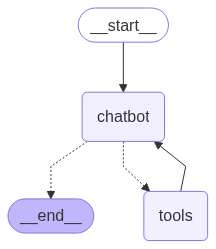

In [19]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [ ]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

## OK it's time to add Memory!

### BUT WAIT!

We have this whole Graph maintaining the state and appending to the state.

Why isn't this handling memory?

### This is a crucial point for understanding LangGraph

> A super-step can be considered a single iteration over the graph nodes. Nodes that run in parallel are part of the same super-step, while nodes that run sequentially belong to separate super-steps.


One "Super-Step" of the graph represents one invocation of passing messages between agents.

In idomatic LangGraph, you call invoke to run your graph for each super-step; for each interaction.

The reducer handles state updates automatically within one super-step, but not between them.

That is what checkpointing achieves.

In [34]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [ ]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

In [ ]:
graph.get_state(config)

In [ ]:
# Most recent first

list(graph.get_state_history(config))

### LangGraph gives you tools to set the state back to a prior point in time, to branch off:

```
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

And this allows you to build stable systems that can be recovered and rerun from any prior checkpoint.

### And now let's store in SQL

### And this is the power of LangGraph.

In [10]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

In [ ]:
# Steps 1 and 2
graph_builder = StateGraph(State)


# Step 3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [ ]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()